# Getting started with prtecan

In [1]:
import hashlib
import os
import warnings

import arviz as az
import lmfit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from clophfit import prtecan
from clophfit.binding import fitting, plotting
from clophfit.prtecan import Titration, TitrationAnalysis

%load_ext autoreload
%autoreload 2

os.chdir("../../tests/Tecan/140220/")

## Parsing a Single Tecan File

A Tecan file comprises of multiple label blocks, each with its unique metadata. This metadata provides critical details and context for the associated label block. In addition, the Tecan file itself also has its overarching metadata that describes its overall content.

When the KEYS for label blocks are identical, it indicates that these label blocks are equivalent - meaning, they contain the same measurements. The equality of KEYS plays a significant role in parsing and analyzing Tecan files, as it assists in identifying and grouping similar measurement sets together. This understanding of label block equivalence based on KEY similarity is critical when working with Tecan files.

In [2]:
tf = prtecan.Tecanfile("../290212_6.38.xls")
lb0 = tf.labelblocks[0]
tf.metadata

{'Device: infinite 200': Metadata(value='Serial number: 810002712', unit=['Serial number of connected stacker:']),
 'Firmware: V_2.11_04/08_InfiniTe (Apr  4 2008/14.37.11)': Metadata(value='MAI, V_2.11_04/08_InfiniTe (Apr  4 2008/14.37.11)', unit=None),
 'Date:': Metadata(value='29/02/2012', unit=None),
 'Time:': Metadata(value='15.57.05', unit=None),
 'System': Metadata(value='TECANROBOT', unit=None),
 'User': Metadata(value='TECANROBOT\\Administrator', unit=None),
 'Plate': Metadata(value='PE 96 Flat Bottom White   [PE.pdfx]', unit=None),
 'Plate-ID (Stacker)': Metadata(value='Plate-ID (Stacker)', unit=None),
 'Shaking (Linear) Duration:': Metadata(value=50, unit=['s']),
 'Shaking (Linear) Amplitude:': Metadata(value=2, unit=['mm'])}

In [3]:
print("Metadata:\n", lb0.metadata, "\n")
print("Data:\n", lb0.data)

Metadata:
 {'Label': Metadata(value='Label1', unit=None), 'Mode': Metadata(value='Fluorescence Top Reading', unit=None), 'Excitation Wavelength': Metadata(value=400, unit=['nm']), 'Emission Wavelength': Metadata(value=535, unit=['nm']), 'Excitation Bandwidth': Metadata(value=20, unit=['nm']), 'Emission Bandwidth': Metadata(value=25, unit=['nm']), 'Gain': Metadata(value=81, unit=['Manual']), 'Number of Flashes': Metadata(value=10, unit=None), 'Integration Time': Metadata(value=20, unit=['µs']), 'Lag Time': Metadata(value='µs', unit=None), 'Settle Time': Metadata(value='ms', unit=None), 'Start Time:': Metadata(value='29/02/2012 15.57.55', unit=None), 'Temperature': Metadata(value=26.0, unit=['°C']), 'End Time:': Metadata(value='29/02/2012 15.58.35', unit=None)} 

Data:
 {'A01': 30072.0, 'A02': 27276.0, 'A03': 22249.0, 'A04': 30916.0, 'A05': 27943.0, 'A06': 25130.0, 'A07': 26765.0, 'A08': 27836.0, 'A09': 23084.0, 'A10': 31370.0, 'A11': 16890.0, 'A12': 22136.0, 'B01': 22336.0, 'B02': 31327

## Group a list of tecan files into a titration

The command Titration.fromlistfile("../listfile") reads a list of Tecan files, identifies unique measurements in each file, groups matching ones, and combines them into a titration set for further analysis.

In [4]:
warnings.filterwarnings("ignore", category=UserWarning, module="clophfit.prtecan")

tit = Titration.fromlistfile("./list.pH")
print(tit.conc, "\n")
lbg0 = tit.labelblocksgroups[0]
lbg1 = tit.labelblocksgroups[1]
lbg0.metadata, lbg1.metadata

[9.06, 8.35, 7.7, 7.08, 6.44, 5.83, 4.99] 



({'Label': Metadata(value='Label1', unit=None),
  'Mode': Metadata(value='Fluorescence Top Reading', unit=None),
  'Excitation Wavelength': Metadata(value=400, unit=['nm']),
  'Emission Wavelength': Metadata(value=535, unit=['nm']),
  'Excitation Bandwidth': Metadata(value=20, unit=['nm']),
  'Emission Bandwidth': Metadata(value=25, unit=['nm']),
  'Number of Flashes': Metadata(value=10, unit=None),
  'Integration Time': Metadata(value=20, unit=['µs']),
  'Lag Time': Metadata(value='µs', unit=None),
  'Settle Time': Metadata(value='ms', unit=None),
  'Gain': Metadata(value=93, unit=None)},
 {'Label': Metadata(value='Label2', unit=None),
  'Mode': Metadata(value='Fluorescence Top Reading', unit=None),
  'Excitation Wavelength': Metadata(value=485, unit=['nm']),
  'Emission Wavelength': Metadata(value=535, unit=['nm']),
  'Excitation Bandwidth': Metadata(value=25, unit=['nm']),
  'Emission Bandwidth': Metadata(value=25, unit=['nm']),
  'Number of Flashes': Metadata(value=10, unit=None),


In [5]:
lbg0.labelblocks[5].metadata["Temperature"]

Metadata(value=25.3, unit=['°C'])

In [6]:
lbg0.data["H12"], lbg1.data[
    "H12"
], lbg0.data_buffersubtracted, lbg1.data_buffersubtracted

([15112.0, 16345.0, 19169.0, 21719.0, 22128.0, 23532.0, 21909.0],
 [5372.0, 4196.0, 2390.0, 1031.0, 543.0, 427.0, 371.0],
 {},
 {})

Start with platescheme loading to set buffer wells (and consequently buffer values).

Labelblocks group will be populated with data buffer subtracted with/out normalization.

In [7]:
tit.load_scheme("./scheme.txt")
print(f"Buffer wells : {tit.scheme.buffer}")
print(f"Ctrl wells   : {tit.scheme.ctrl}")
print(f"CTR name:wells {tit.scheme.names}")

Buffer wells : ['D01', 'E01', 'D12', 'E12']
Ctrl wells   : ['C12', 'F01', 'F12', 'B01', 'A12', 'G12', 'A01', 'H12', 'H01', 'B12', 'C01', 'G01']
CTR name:wells {'G03': {'H12', 'B12', 'A01'}, 'NTT': {'C12', 'F01', 'F12'}, 'S202N': {'G12', 'H01', 'C01'}, 'V224Q': {'B01', 'G01', 'A12'}}


In [8]:
lbg0.data["H12"], lbg1.data["H12"], lbg0.data_buffersubtracted[
    "H12"
], lbg1.data_buffersubtracted["H12"], tit.data

([15112.0, 16345.0, 19169.0, 21719.0, 22128.0, 23532.0, 21909.0],
 [5372.0, 4196.0, 2390.0, 1031.0, 543.0, 427.0, 371.0],
 [4226.5, 5005.25, 7829.75, 10291.75, 10238.75, 11381.25, 9566.0],
 [5319.25, 4143.25, 2336.75, 977.0, 486.25, 367.75, 310.5],
 None)

In [9]:
tit.load_additions("./additions.pH")
tit.additions

[100, 2, 2, 2, 2, 2, 2]

In [10]:
lbg0.data["H12"], lbg1.data["H12"], lbg0.data_buffersubtracted[
    "H12"
], lbg1.data_buffersubtracted["H12"], tit.data[0]["H12"], tit.data[1]["H12"]

([15112.0, 16345.0, 19169.0, 21719.0, 22128.0, 23532.0, 21909.0],
 [5372.0, 4196.0, 2390.0, 1031.0, 543.0, 427.0, 371.0],
 [4226.5, 5005.25, 7829.75, 10291.75, 10238.75, 11381.25, 9566.0],
 [5319.25, 4143.25, 2336.75, 977.0, 486.25, 367.75, 310.5],
 [4226.5,
  5105.3550000000005,
  8142.9400000000005,
  10909.255000000001,
  11057.85,
  12519.375000000002,
  10713.920000000002],
 [5319.25,
  4226.115,
  2430.2200000000003,
  1035.6200000000001,
  525.1500000000001,
  404.52500000000003,
  347.76000000000005])

The order in which you apply dilution correction and plate scheme can impact your intermediate results, even though the final results might be the same.

    Dilution correction adjusts the measured data to account for any dilutions made during sample preparation. This typically involves multiplying the measured values by the dilution factor to estimate the true concentration of the sample.

    A plate scheme describes the layout of the samples on a plate (common in laboratory experiments, such as those involving microtiter plates). The plate scheme may involve rearranging or grouping the data in some way based on the physical location of the samples on the plate.

In [11]:
tit = Titration.fromlistfile("./list.pH")
lbg0 = tit.labelblocksgroups[0]
lbg1 = tit.labelblocksgroups[1]
tit.load_additions("./additions.pH")
lbg0.data["H12"], lbg1.data[
    "H12"
], lbg0.data_buffersubtracted, lbg1.data_buffersubtracted, tit.data

([15112.0, 16345.0, 19169.0, 21719.0, 22128.0, 23532.0, 21909.0],
 [5372.0, 4196.0, 2390.0, 1031.0, 543.0, 427.0, 371.0],
 {},
 {},
 [None, None])

In [12]:
tit.load_scheme("./scheme.txt")
lbg0.data["H12"], lbg1.data["H12"], lbg0.data_buffersubtracted[
    "H12"
], lbg1.data_buffersubtracted["H12"], tit.data[0]["H12"], tit.data[1]["H12"]

([15112.0, 16345.0, 19169.0, 21719.0, 22128.0, 23532.0, 21909.0],
 [5372.0, 4196.0, 2390.0, 1031.0, 543.0, 427.0, 371.0],
 [4226.5, 5005.25, 7829.75, 10291.75, 10238.75, 11381.25, 9566.0],
 [5319.25, 4143.25, 2336.75, 977.0, 486.25, 367.75, 310.5],
 [4226.5,
  5105.3550000000005,
  8142.9400000000005,
  10909.255000000001,
  11057.85,
  12519.375000000002,
  10713.920000000002],
 [5319.25,
  4226.115,
  2430.2200000000003,
  1035.6200000000001,
  525.1500000000001,
  404.52500000000003,
  347.76000000000005])

### Reassign Buffer Wells

You can reassess buffer wells, updating the data to account for any dilution (additions) and subtracting the updated buffer value. This is a handy feature that gives you more control over your analysis.

For instance, consider the following data for a particular well:

In [13]:
print(tit.labelblocksgroups[1].data["D01"])
print(tit.labelblocksgroups[1].data_buffersubtracted["D01"])
print(tit.data[1]["D01"])

[51.0, 52.0, 50.0, 51.0, 55.0, 58.0, 57.0]
[-1.75, -0.75, -3.25, -3.0, -1.75, -1.25, -3.5]
[-1.75, -0.765, -3.38, -3.18, -1.8900000000000001, -1.375, -3.9200000000000004]


You can reassign buffer wells using the `buffer_wells` attribute:

In [14]:
tit.buffer_wells = ["D01", "E01"]

This updates the data for the specified wells, correcting for dilution and subtracting the buffer value:

In [15]:
print(tit.labelblocksgroups[1].data["D01"])
print(tit.labelblocksgroups[1].data_buffersubtracted["D01"])
print(tit.data[1]["D01"])

[51.0, 52.0, 50.0, 51.0, 55.0, 58.0, 57.0]
[1.0, 2.0, -1.5, -0.5, 1.5, 3.0, 1.5]
[1.0, 2.04, -1.56, -0.53, 1.62, 3.3000000000000003, 1.6800000000000002]


The data remains:
- unchanged in `labelblocksgroups[].data`
- adjusted buffer subtracted in `labelblocksgroups[].data_buffersubtracted`
- adjusted buffer subtracted and dilution corrected in `data`.

## Titration Analysis

In [16]:
ph_an = TitrationAnalysis.fromlistfile("./list.pH")
ph_an.load_scheme("./scheme.txt")
ph_an.load_additions("additions.pH")
# g = ph_an.plot_buffer()
ph_an.fitresults[1]

,ss,msg,df,tval,chisqr,K,SA,SB,sK,sSA,sSB,ctrl
A10,1,Both actual and predicted relative reductions ...,4,2.776445,20279.530259,7.033038,1119.884631,7025.032888,0.130334,301.139633,291.774056,NaN
B11,1,Both actual and predicted relative reductions ...,4,2.776445,7414.609269,6.992139,754.743323,4612.131795,0.120804,185.223756,173.713451,NaN
G05,1,Both actual and predicted relative reductions ...,4,2.776445,9532.835407,7.938832,221.298110,5681.555904,0.109167,155.934219,331.127173,NaN
D02,1,Both actual and predicted relative reductions ...,4,2.776445,9397.974038,7.017346,680.510795,4592.657252,0.133984,206.335639,197.438471,NaN
C12,1,Both actual and predicted relative reductions ...,4,2.776445,1134.561624,7.576295,354.043527,2524.990943,0.086689,59.086336,89.063816,NTT
...,...,...,...,...,...,...,...,...,...,...,...,...
D06,1,Both actual and predicted relative reductions ...,4,2.776445,1369.989515,7.453487,122.953471,3336.695752,0.063402,67.382646,91.558407,NaN
B02,1,Both actual and predicted relative reductions ...,4,2.776445,27725.369189,7.077064,713.094975,3323.091356,0.344518,345.902027,347.060244,NaN
D08,1,Both actual and predicted relative reductions ...,4,2.776445,171.491778,8.000474,182.100151,2936.186063,0.029681,20.619276,46.797909,NaN
B03,1,Both actual and predicted relative reductions ...,4,2.776445,10448.806742,6.895277,857.241503,5872.418044,0.110830,229.419603,199.075107,NaN


In [17]:
well = "D05"
y0 = np.array(ph_an.data[0][well])
y1 = np.array(ph_an.labelblocksgroups[1].data_buffersubtracted[well])
# y1 = np.array(ph_an.data[1][well])
x = np.array(ph_an.conc)
ds = fitting.Dataset(x, {"y1": y1}, is_ph=True)
rfit = fitting.fit_binding_glob(ds)
rfit.result.params

name,value,standard error,relative error,initial value,min,max,vary
S0_y1,9396.44390,71.8116257,(0.76%),8696.25,0.00000000,inf,True
S1_y1,433.933479,32.5574868,(7.50%),398.5,-inf,inf,True
K,7.97431923,0.01417813,(0.18%),7.7,3.00000000,11.0000000,True


### Fitting

In [18]:
ph_an.datafit_params = {"bg": 1, "nrm": 0, "dil": 0}
ph_an.datafit[1]["E06"]

[9215.25, 7038.25, 3318.75, 1361.0, 736.25, 558.75, 284.5]

In [19]:
ph_an.datafit[1]["E06"]

[9215.25, 7038.25, 3318.75, 1361.0, 736.25, 558.75, 284.5]

In [20]:
set(ph_an.__dict__.keys()) - set(tit.__dict__.keys())

{'_datafit', '_datafit_params', '_fit_args', '_fitresults', 'fz', 'keys_unk'}

In [21]:
rfit.result

In [22]:
remcee = rfit.mini.emcee(burn=50, steps=500, workers=8, thin=10)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 84.00it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [40.47854612 30.3874557  38.21067418]


[7.95, 7.99]


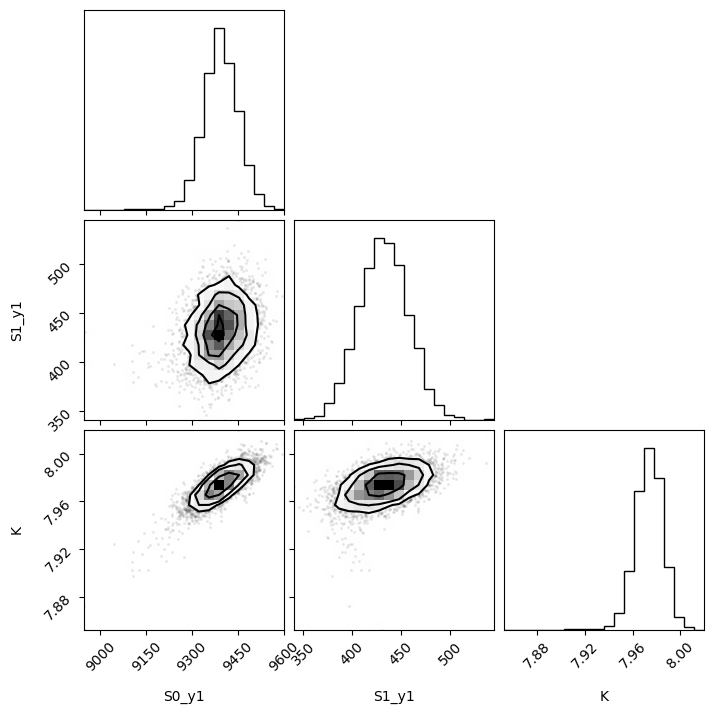

In [23]:
f, hdi = plotting.plot_emcee(remcee)
print(hdi)

Value at which the probability of being higher is 99%: 7.951271083896513


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

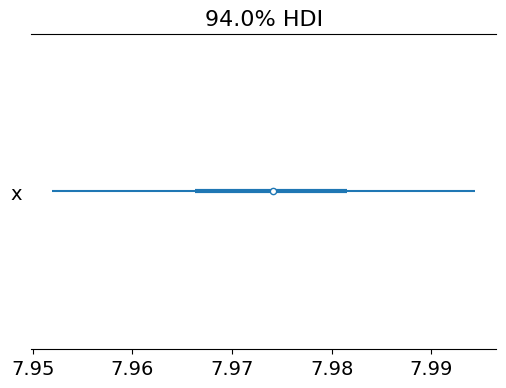

In [24]:
samples = remcee.flatchain[["K"]]
# Convert the dictionary of flatchains to an ArviZ InferenceData object
samples_dict = {key: np.array(val) for key, val in samples.items()}
idata = az.from_dict(posterior=samples_dict)
k_samples = idata.posterior["K"].values
percentile_value = np.percentile(k_samples, 3)
print(f"Value at which the probability of being higher is 99%: {percentile_value}")

az.plot_forest(k_samples)

## Cl titration analysis

In [25]:
cl_an = prtecan.TitrationAnalysis.fromlistfile("list.cl")
cl_an.load_scheme("scheme.txt")
cl_an.scheme

PlateScheme(file='scheme.txt', _buffer=['D01', 'E01', 'D12', 'E12'], _ctrl=['C12', 'F01', 'F12', 'B01', 'A12', 'G12', 'A01', 'H12', 'H01', 'B12', 'C01', 'G01'], _names={'G03': {'H12', 'B12', 'A01'}, 'NTT': {'C12', 'F01', 'F12'}, 'S202N': {'G12', 'H01', 'C01'}, 'V224Q': {'B01', 'G01', 'A12'}})

In [26]:
cl_an.load_additions("additions.cl")
print(cl_an.conc)
cl_an.conc = prtecan.calculate_conc(cl_an.additions, 1000)
cl_an.conc

[0, 0, 0, 0, 0, 0, 0, 0, 0]


array([  0.        ,  17.54385965,  34.48275862,  50.84745763,
        66.66666667,  81.96721311,  96.77419355, 138.46153846,
       164.17910448])

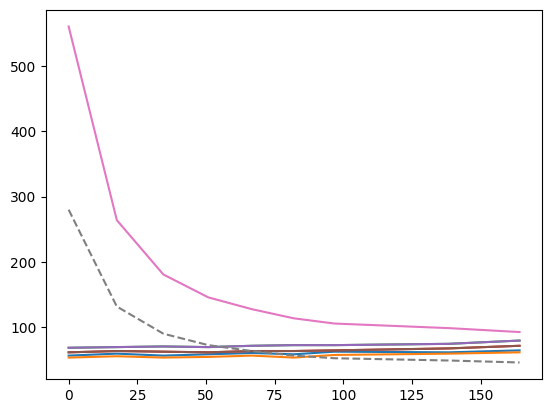

In [27]:
lbg = cl_an.labelblocksgroups[1]
x = cl_an.conc
plt.plot(x, lbg.data["D01"])
plt.plot(x, lbg.data["E01"])
plt.plot(x, lbg.data["D12"])
plt.plot(x, lbg.data["E12"])
plt.plot(x, cl_an.labelblocksgroups[1].data["D12"])
plt.plot(x, cl_an.labelblocksgroups[1].data["E12"])
plt.plot(x, lbg.data["A11"])
plt.plot(x, np.array(cl_an.labelblocksgroups[1].data["A11"]) / 2, "--")

In [28]:
lbg.labelblocks[1].buffer

62.5

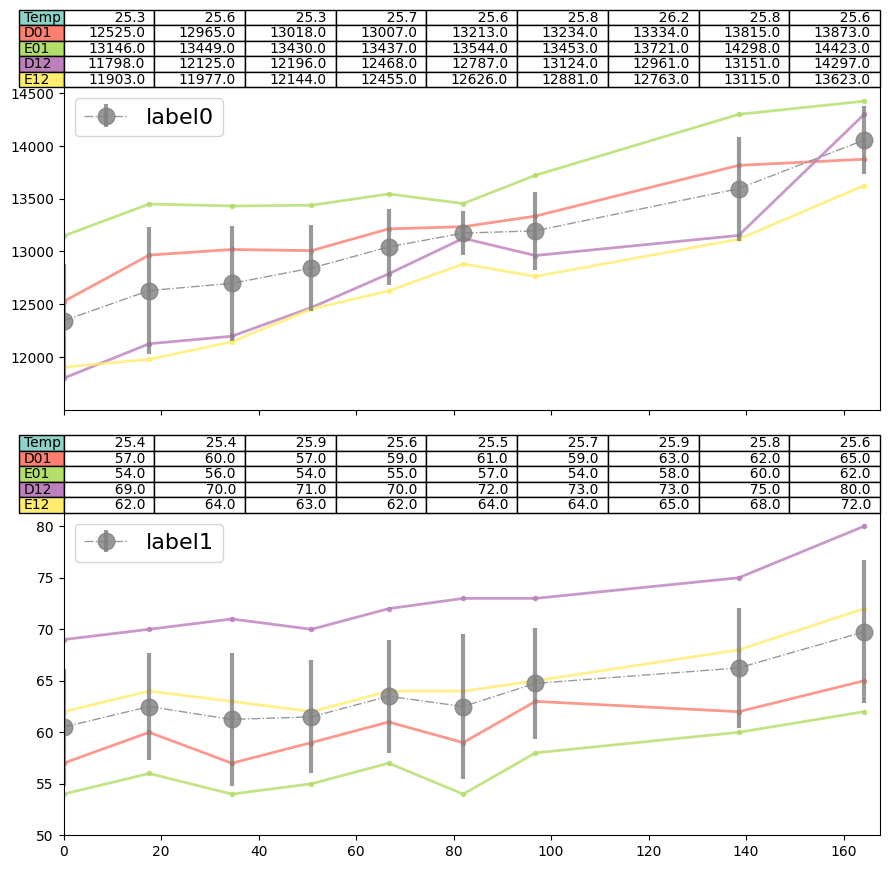

In [29]:
f = cl_an.plot_buffer()

## Fitting

TitrationAnalysis class need API changes to better rationalize its use.

In [30]:
# ph_an.fit("pH", fin=-1, tval=0.95)
type(ph_an.fitresults)

list

In [31]:
ph_an.fitresults[1].loc[["H06", "A01"]]

,ss,msg,df,tval,chisqr,K,SA,SB,sK,sSA,sSB,ctrl
H06,1,Both actual and predicted relative reductions ...,4,2.776445,3416.655898,8.034842,482.109541,9732.701522,0.039966,91.321187,215.364886,NaN
A01,1,Both actual and predicted relative reductions ...,4,2.776445,1532.081955,7.935068,241.064577,4995.741432,0.050194,62.568209,132.336909,G03


In [32]:
key = "H06"
lbg = ph_an.labelblocksgroups[1]
x = ph_an.conc
y = lbg.data[key]
dd = prtecan.prtecan.fit_titration("pH", x[:-1], y[:-1])
dd

,ss,msg,df,tval,chisqr,K,SA,SB,sK,sSA,sSB
0,1,Both actual and predicted relative reductions ...,3,3.182446,85.730623,8.044499,583.667709,9807.482415,0.00765,19.955025,39.796818


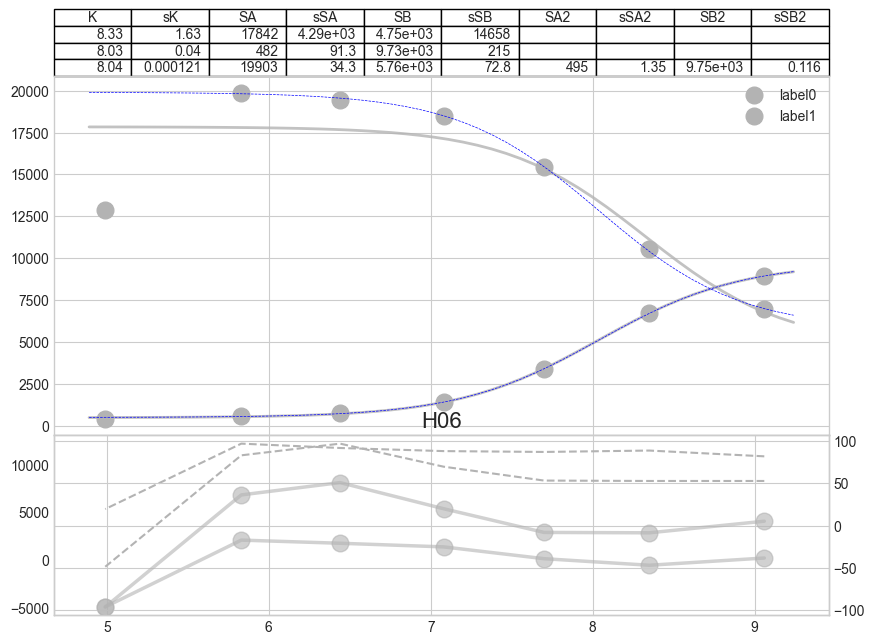

In [33]:
ph_an.plot_well("H06")

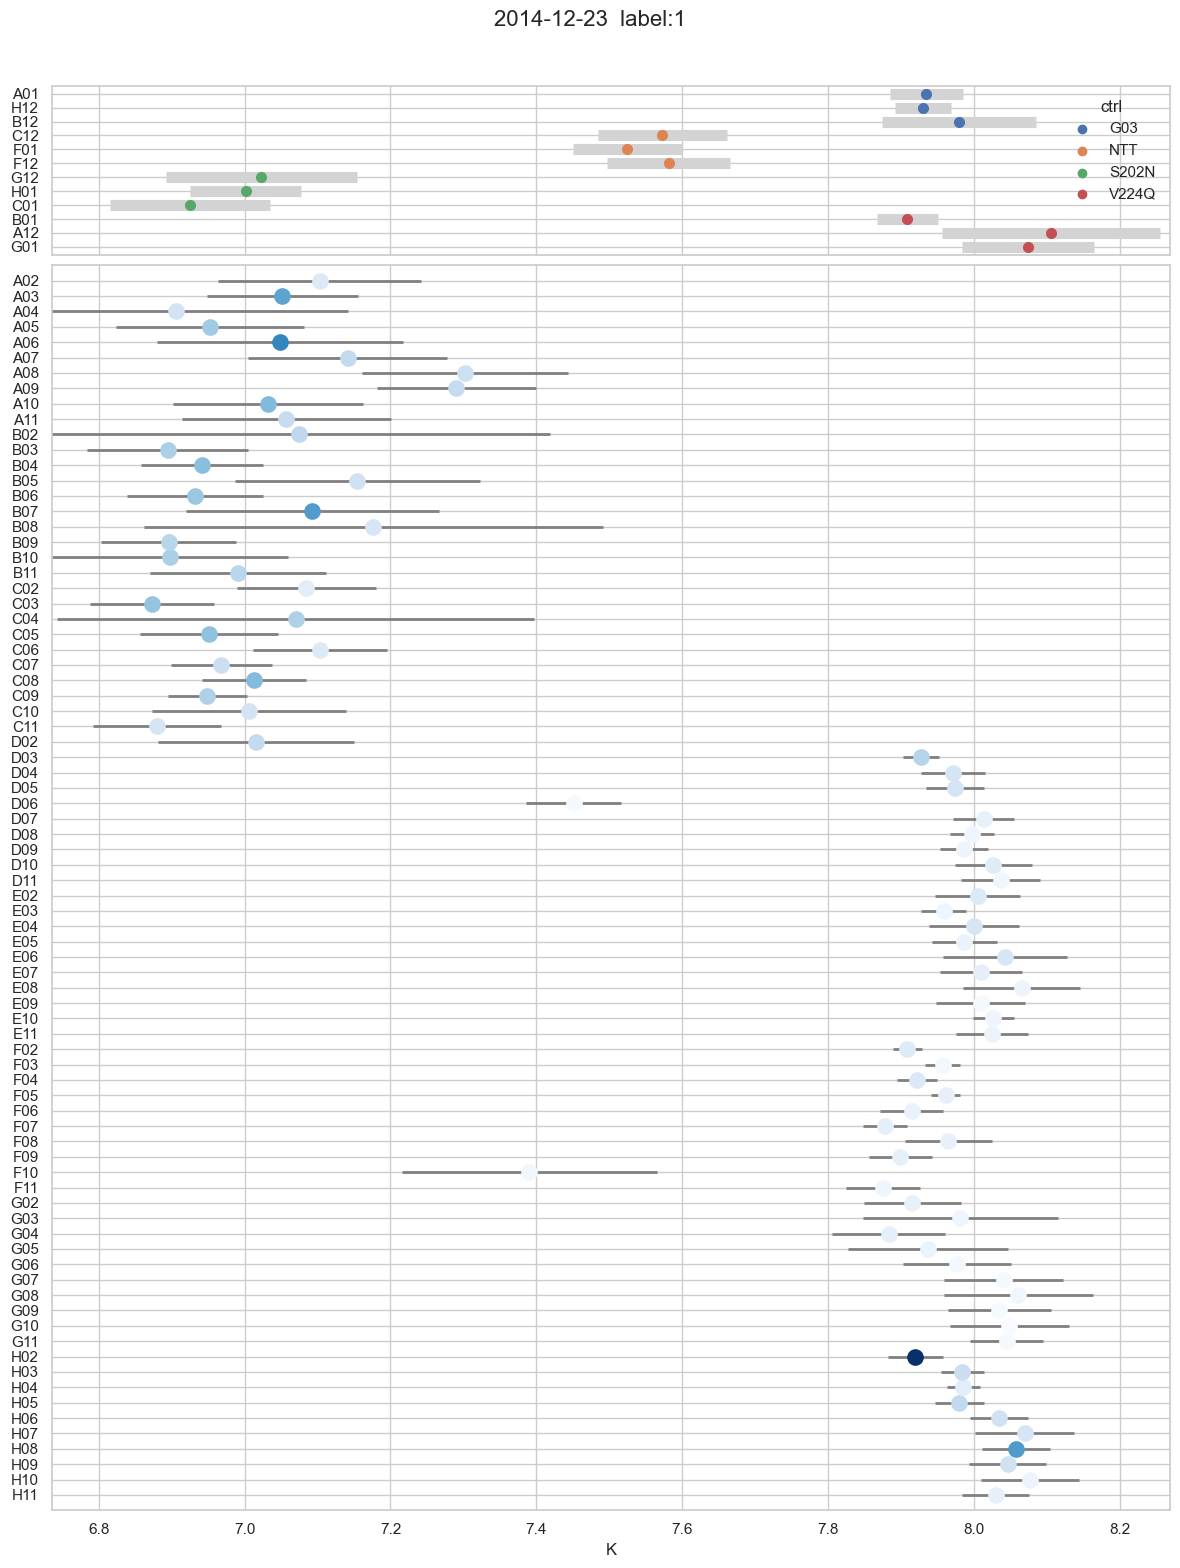

In [34]:
f = ph_an.plot_k(1, title="2014-12-23")

In [35]:
cl_an.fit("Cl", fin=None)

[     ss                                                msg  df      tval  \
 A10   1  Both actual and predicted relative reductions ...   6  2.446912   
 B11   1  Both actual and predicted relative reductions ...   6  2.446912   
 G05   1  Both actual and predicted relative reductions ...   6  2.446912   
 D02   1  Both actual and predicted relative reductions ...   6  2.446912   
 C12   1  Both actual and predicted relative reductions ...   6  2.446912   
 ..   ..                                                ...  ..       ...   
 D06   1  Both actual and predicted relative reductions ...   6  2.446912   
 B02   1  Both actual and predicted relative reductions ...   6  2.446912   
 D08   1  Both actual and predicted relative reductions ...   6  2.446912   
 B03   1  Both actual and predicted relative reductions ...   6  2.446912   
 C08   1  Both actual and predicted relative reductions ...   6  2.446912   
 
             chisqr             K            SA            SB            s

In [36]:
# cl_an.plot_all_wells("cl.pdf")

In [37]:
ph_an.print_fitting(2)

          K      sK      SA     sSA      SB     sSB     SA2    sSA2     SB2    sSB2
  G03
A01    8.04    0.14   10423     234    3445     628     600     425    5038      95 
H12    7.94    0.01   10461     103    3291     191     320       2    5695      11 
B12    8.21    0.26    6709     123    3208     363     393     424    2842     181 
  NTT
C12    7.72    0.11   10657     739    4208     665     668     328    2497      24 
F01    7.69    0.06   34398     411   13054     839    2216     439    7940      30 
F12    7.83    0.05   11207     212    4414     179    1017     182    2781      31 
  S202N
G12    7.32    0.15   11292    1032    5704     339     784     238    2313      26 
H01    7.42    0.20   22945    1816   13779     298    2905     744    5095      17 
C01    7.88    0.27   27413    2375   18866     184    5044    1135    7046     596 
  V224Q
B01    7.93    0.01   29401     265   12881     331     454      62   15266      34 
A12    8.25    0.16   17320     661   

### selection

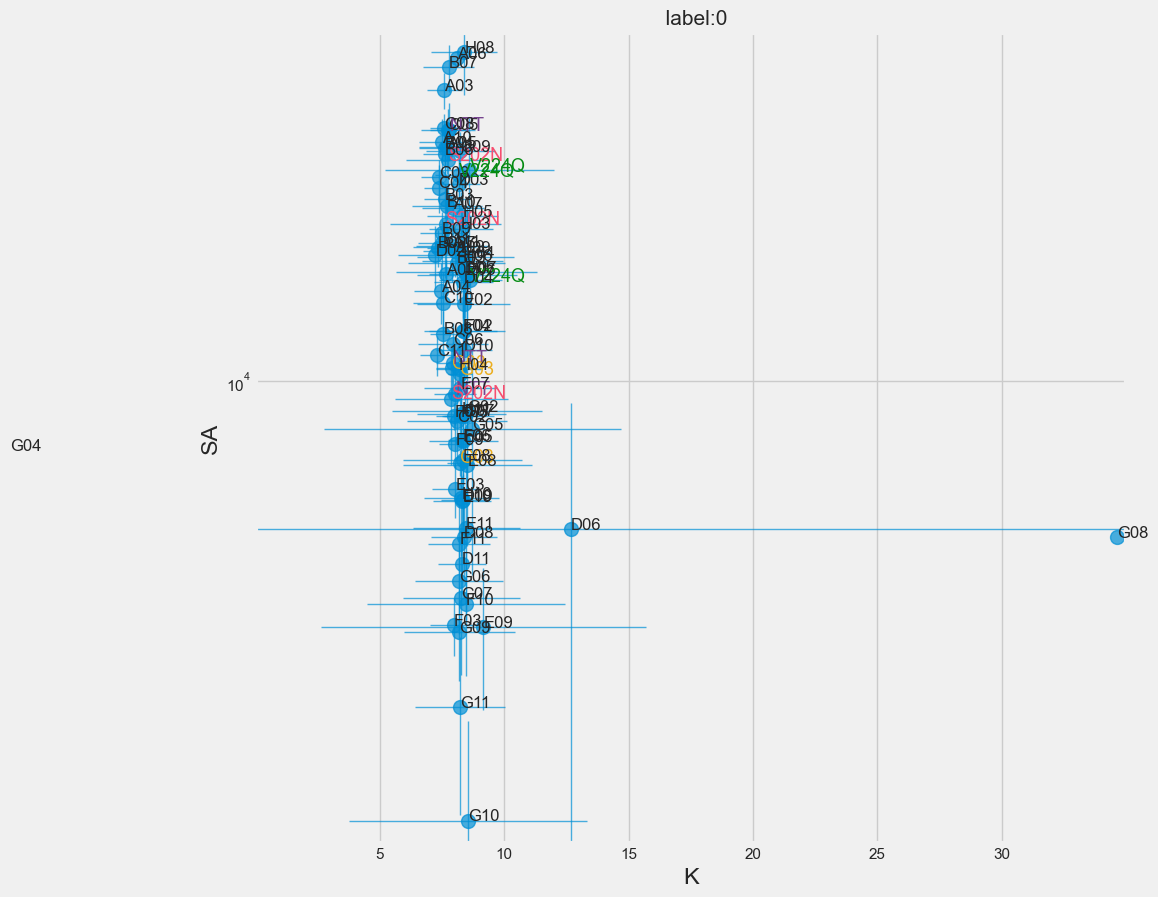

In [38]:
f = ph_an.plot_ebar(0)

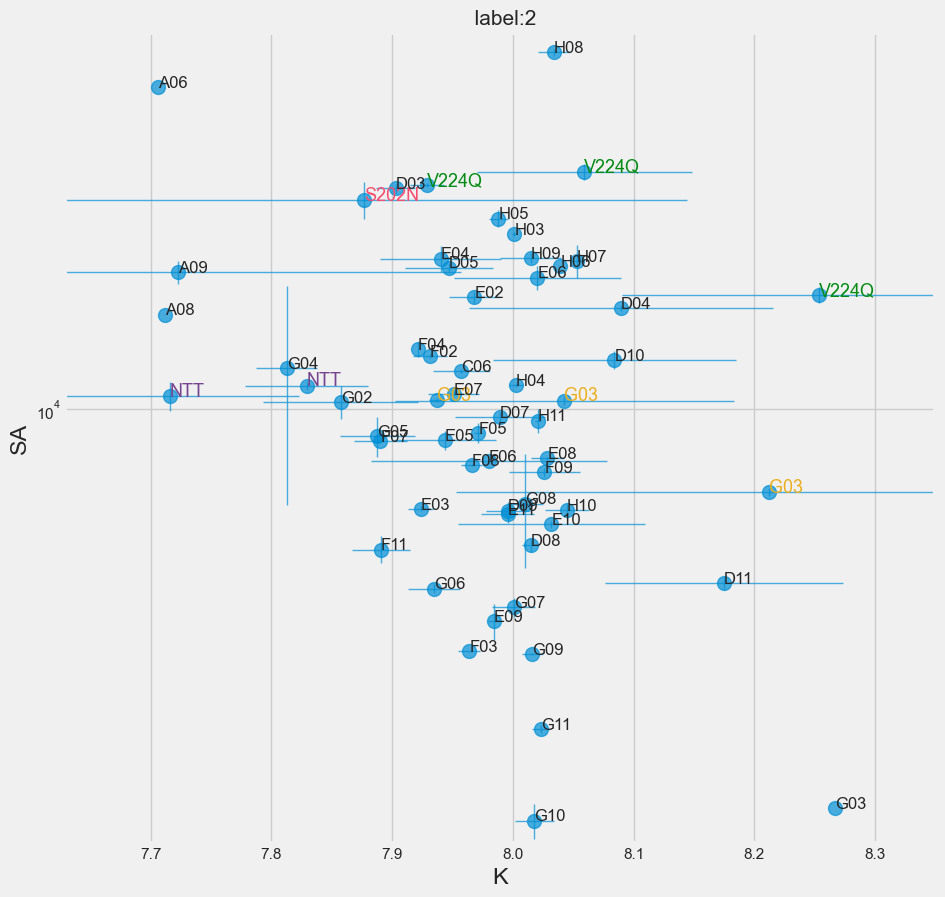

In [39]:
f = ph_an.plot_ebar(2, xmin=7.7, ymin=25)

/home/dan/workspace/ClopHfit/.hatch/clophfit/lib/python3.11/site-packages/seaborn/axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/home/dan/workspace/ClopHfit/.hatch/clophfit/lib/python3.11/site-packages/seaborn/axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/home/dan/workspace/ClopHfit/.hatch/clophfit/lib/python3.11/site-packages/seaborn/axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/home/dan/workspace/ClopHfit/.hatch/clophfit/lib/python3.11/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/dan/workspace/ClopHfit/.hatch/clophfit/lib/python3.11/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  

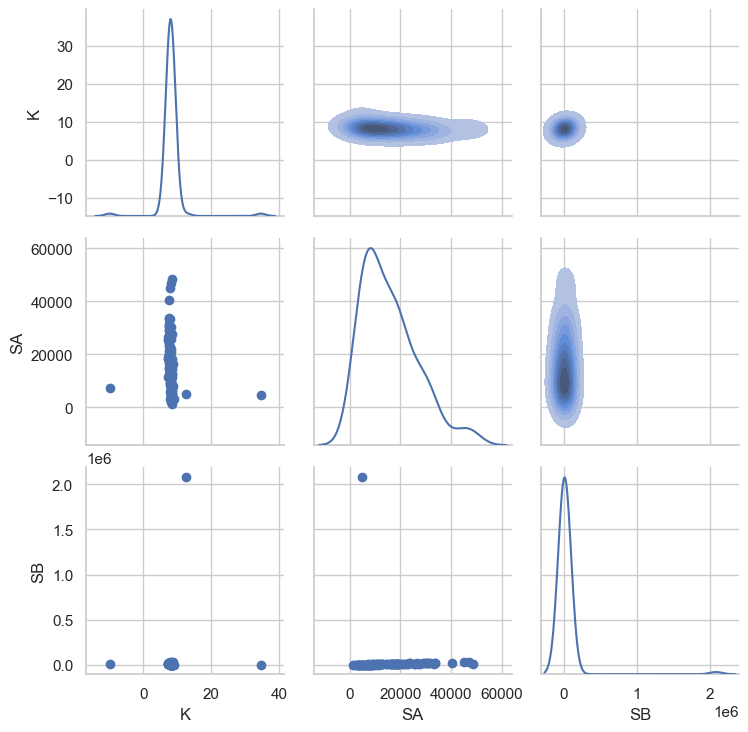

In [40]:
import seaborn as sb

sb.set_style("whitegrid")
g = sb.PairGrid(
    ph_an.fitresults[0],
    x_vars=["K", "SA", "SB"],
    y_vars=["K", "SA", "SB"],
    # hue='SB',
    palette="Blues",
    diag_sharey=False,
)

g.map_lower(plt.scatter)
g.map_upper(sb.kdeplot, fill=True)
g.map_diag(sb.kdeplot)

Fit first (0) and second (1) dataset and global (2).

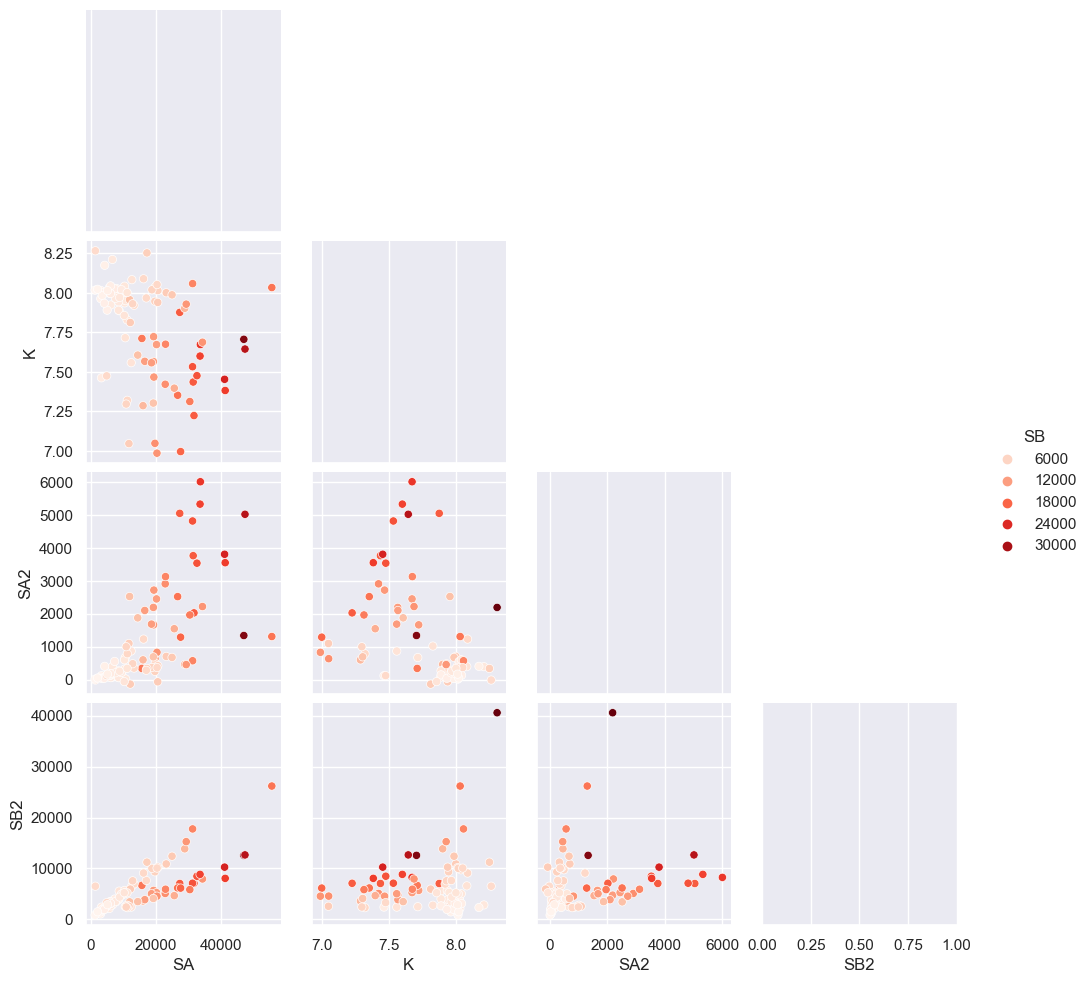

In [41]:
with sb.axes_style("darkgrid"):
    g = sb.pairplot(
        ph_an.fitresults[2][["SA", "SB", "K", "SA2", "SB2"]],
        hue="SB",
        palette="Reds",
        corner=True,
        diag_kind="kde",
    )

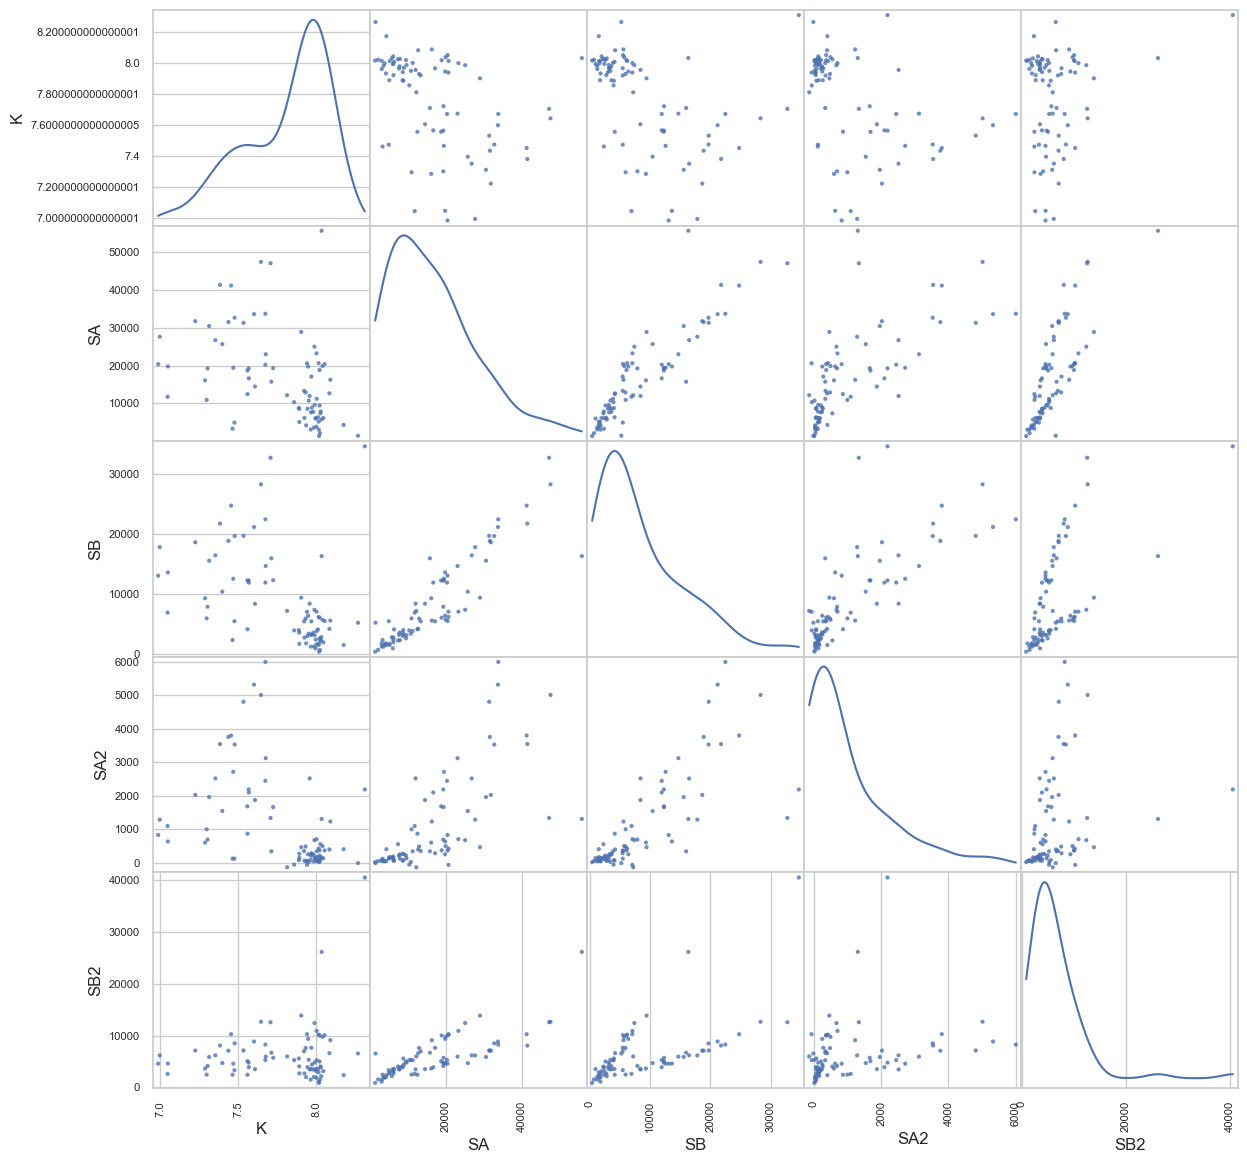

In [42]:
from pandas.plotting import scatter_matrix


def plot_matrix(tit, lb):
    df = tit.fitresults[lb].loc[tit.keys_unk]
    try:
        f = scatter_matrix(
            df[["K", "SA", "SB", "SA2", "SB2"]],
            figsize=(14, 14),
            diagonal="kde",
            alpha=0.8,
        )
    except KeyError:
        f = scatter_matrix(
            df[["K", "SA", "SB"]], figsize=(10, 10), diagonal="kde", alpha=0.8
        )
    return f


f = plot_matrix(ph_an, 2)

### combining

In [43]:
res_unk = ph_an.fitresults[1].loc[ph_an.keys_unk].sort_index()
res_unk["well"] = res_unk.index

<Figure size 2400x1400 with 0 Axes>

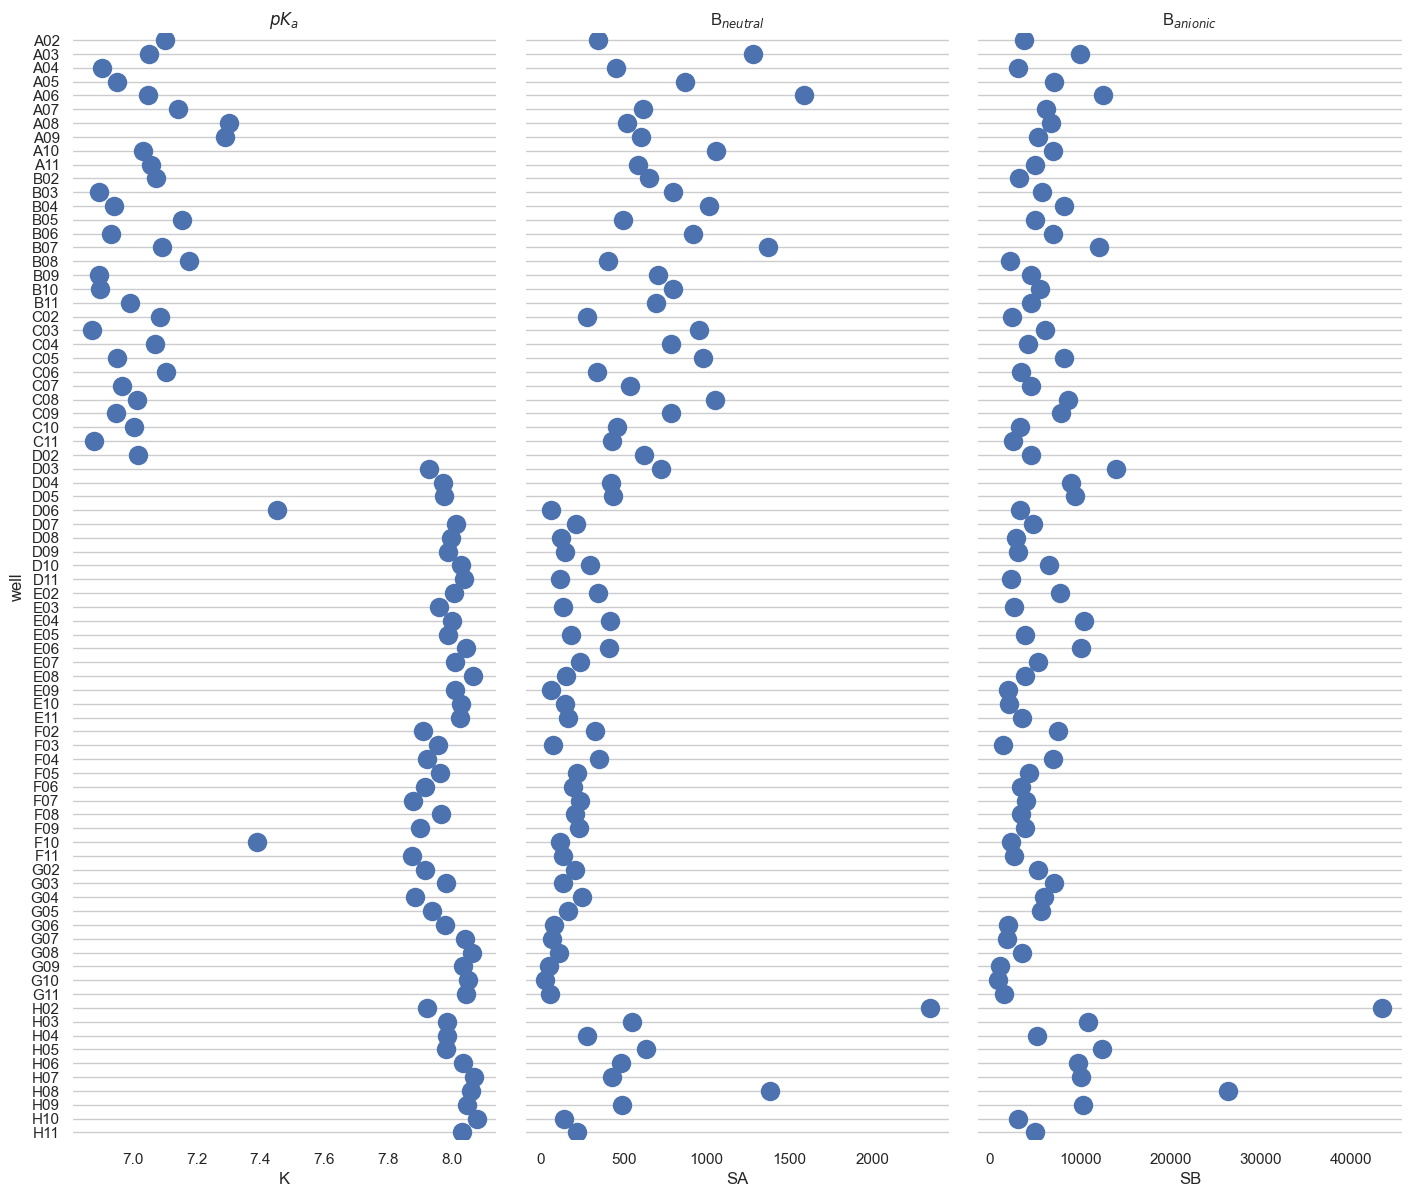

In [44]:
# g = sns.FacetGrid(data=res2, row='well',  margin_titles=True)
# g.map(plt.errorbar, 'K', range(1), xerr='sK', palette='Oranges_d') # x, y,
f = plt.figure(figsize=(24, 14))

# Make the PairGrid
g = sb.PairGrid(
    res_unk,
    x_vars=["K", "SA", "SB"],
    y_vars="well",
    height=12,
    aspect=0.4,
)


# Draw a dot plot using the stripplot function
g.map(sb.stripplot, size=14, orient="h", palette="Set2", edgecolor="gray")

# Use the same x axis limits on all columns and add better labels
# g.set(xlim=(0, 25), xlabel="Crashes", ylabel="")

# Use semantically meaningful titles for the columns
titles = ["$pK_a$", "B$_{neutral}$", "B$_{anionic}$"]


for ax, title in zip(g.axes.flat, titles):
    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sb.despine(left=True, bottom=True)